In [54]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy

In [55]:
data_dir = '../../output/'

In [56]:
def Result_output(index, demand_before, demand_after, filename, depotname, ax, capacity):
    
    demand_base = np.zeros(demand_before.shape)
    increase = np.zeros(demand_before.shape)
    decrease = np.zeros(demand_before.shape)
    
    for i in range(len(demand_before)):
        demand_base[i] = min(demand_before[i],demand_after[i])
        temp = demand_after[i] - demand_before[i]
        if temp >= 0:
            increase[i] = temp
        else:
            decrease[i] = -temp
    
    #fig, ax = plt.subplots(figsize = (10,6))
    ax.bar(index, demand_base, width = 0.4, label = "Base Charger Demand")
    ax.bar(index, increase, width = 0.4, bottom = demand_base, label = "Increased Demand")
    ax.bar(index, decrease, width = 0.4, bottom = demand_base, label = "Decreased Demand")
    ax.set_title(f'{int(capacity/1000)} MWh Battery', fontsize = 18)
    ax.set_ylim(0, max(demand_before) + 500)
    ax.set_xlim(-1, 24.5)
    #ax.set_xlabel("Time of Day (Hour)")
    #ax.set_ylabel("Half Hourly Electricity Demand (kW)")
    ax.legend()
    #ax.figure.savefig("../../fig/"+depotname+"_Battery_Comparison_"+ filename +".png", dpi = 300)
    
    Outputfile = pd.DataFrame()
    Outputfile['Time of Day (Hr)'] = index
    Outputfile['Original Demand (kW)'] = demand_before
    Outputfile['Demand with Battery (kW)'] = demand_after
    
    Outputfile.to_excel("../../output/Battery_Optimization/"+depotname+"_Battery_Comparison_winter_"+ filename +".xlsx")
    

In [57]:
def Depot_opti(Capacity, depotname):
    
    peak_cost = [27.21, 19.50, 5.14]
    
    elec_cost = []
    
    for j in range(48):
        if (j >= 16) & (j < 44):
            elec_cost.append(4.670)
        else:
            elec_cost.append(3.722)
    
    demand = pd.read_csv(data_dir + depotname +'_halfhour_consumption.csv')
    
    demand_day = []
    for i in demand.index:
        #print(i)
        if demand.Half_Hour[i] < 24:
            demand_day.append(demand.Total[i])
        else:
            demand_day[i-48] += demand.Total[i]
    demand_day = np.array(demand_day)  
    
    fig, axs = plt.subplots(2,2,figsize = (20,12))
    plot_count = 0
     
    result = pd.DataFrame(columns = ["Battery Capacity","Peak (8am-6pm)","Peak (6pm-10pm)","Peak (10pm-8am)",
                                    "Monthly Cost of Peak Demand","Monthly Cost of Electricity"])
    for i in Capacity:
        Duration = 2 # hr
        Power = i / Duration # kW

        # In this approach, opmitimizer will try it best to conduct overnight charging.
        Depot_Demand2 = cp.Variable(48, nonneg = True) 
        Battery_Input2 = cp.Variable(48, nonneg = False) 
        SOC2 = cp.Variable(49, nonneg = True) 
        Maximum_Demand2 = cp.Variable(3) 
        
        obj2 =  cp.Minimize( peak_cost @ Maximum_Demand2  + 30 * (elec_cost @ Depot_Demand2) / 100 / 2 + 0.0000001 * sum( Depot_Demand2**2))

        con_set2 = []

        con_set2.append( Depot_Demand2 == demand_day + Battery_Input2 )
        con_set2.append( SOC2 <= i )
        con_set2.append( Battery_Input2 <= Power )
        con_set2.append( Battery_Input2 >= -Power)
        
        for j in range(48):
            con_set2.append( SOC2[j] + Battery_Input2[j] * 0.5 == SOC2[j+1])
        con_set2.append( SOC2[0] == SOC2[48])
        
        for j in range(48):
            if (j >= 16) & (j < 36):
                con_set2.append( Depot_Demand2[j] <= Maximum_Demand2[0] )
            elif (j >= 36) & (j < 44):
                con_set2.append( Depot_Demand2[j] <= Maximum_Demand2[1] )
            else:
                con_set2.append( Depot_Demand2[j] <= Maximum_Demand2[2] )

        prob2 = cp.Problem(obj2, con_set2)
        prob2.solve(solver = "GUROBI")
        
       # if i == 0:
       #     result["Battery Capacity"] = i
       #    result["Peak (8am-6pm)"] = Maximum_Demand2.value[0]
       #     result["Peak (6pm-10pm)"] = Maximum_Demand2.value[1]
       #     result["Peak (10pm-8am)"] = Maximum_Demand2.value[2]
       #     result["Monthly Cost of Peak Demand"] = peak_cost @ Maximum_Demand2.value
       #     result["Monthly Cost of Electricity"] = 30 * (elec_cost @ Depot_Demand2.value) / 1000
       # else:
        result.loc[len(result.index)] = [i, Maximum_Demand2.value[0],Maximum_Demand2.value[1],Maximum_Demand2.value[2],
                                            peak_cost @ Maximum_Demand2.value,30 * (elec_cost @ Depot_Demand2.value) / 200]
         
        Result_output(x, demand_day, Depot_Demand2.value, filename = "Inte_" + str(i), 
                      depotname = depotname, ax = axs[plot_count//2, plot_count%2], 
                      capacity = i)
        
        plot_count += 1
    
    fig.suptitle(f'Peak Shaving Result of {depotname} Depot with Different Battery Capacity',
                fontsize = 20)
    for ax in axs.flat:
        ax.set_xlabel("Time of Day (Hour)", fontsize = 14)
        ax.set_ylabel("Half Hourly Electricity Demand (kW)", fontsize = 14)
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    fig.savefig(f"../../fig/{depotname}_cost_winter.png", dpi =800)
    
    result.to_excel("../../output/Battery_Optimization/"+depotname+"_Cost_winter.xlsx")
    return result

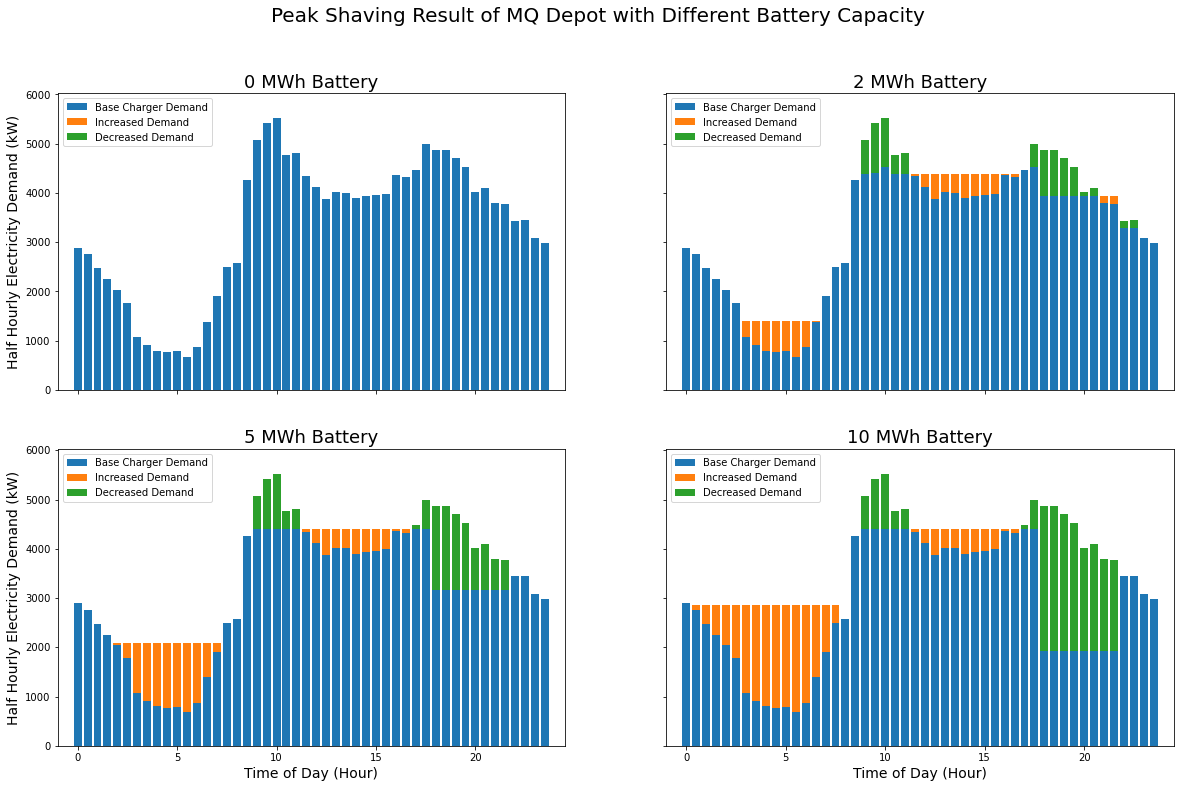

In [58]:
Capacity = [0,2000 ,5000 ,10000]
x = np.arange(48)/2

result = Depot_opti(Capacity, "MQ")

In [59]:
result

,Battery Capacity,Peak (8am-6pm),Peak (6pm-10pm),Peak (10pm-8am),Monthly Cost of Peak Demand,Monthly Cost of Electricity
0,0.0,5520.135892,4874.620844,3448.372140,262982.636888,106701.291737
1,2000.0,4520.135892,3931.542417,3294.126373,216589.784315,106174.816520
2,5000.0,4400.786726,3168.454968,3442.947691,199227.029826,105279.291737
3,10000.0,4400.786726,1918.454968,3442.947691,174852.029826,103857.291737


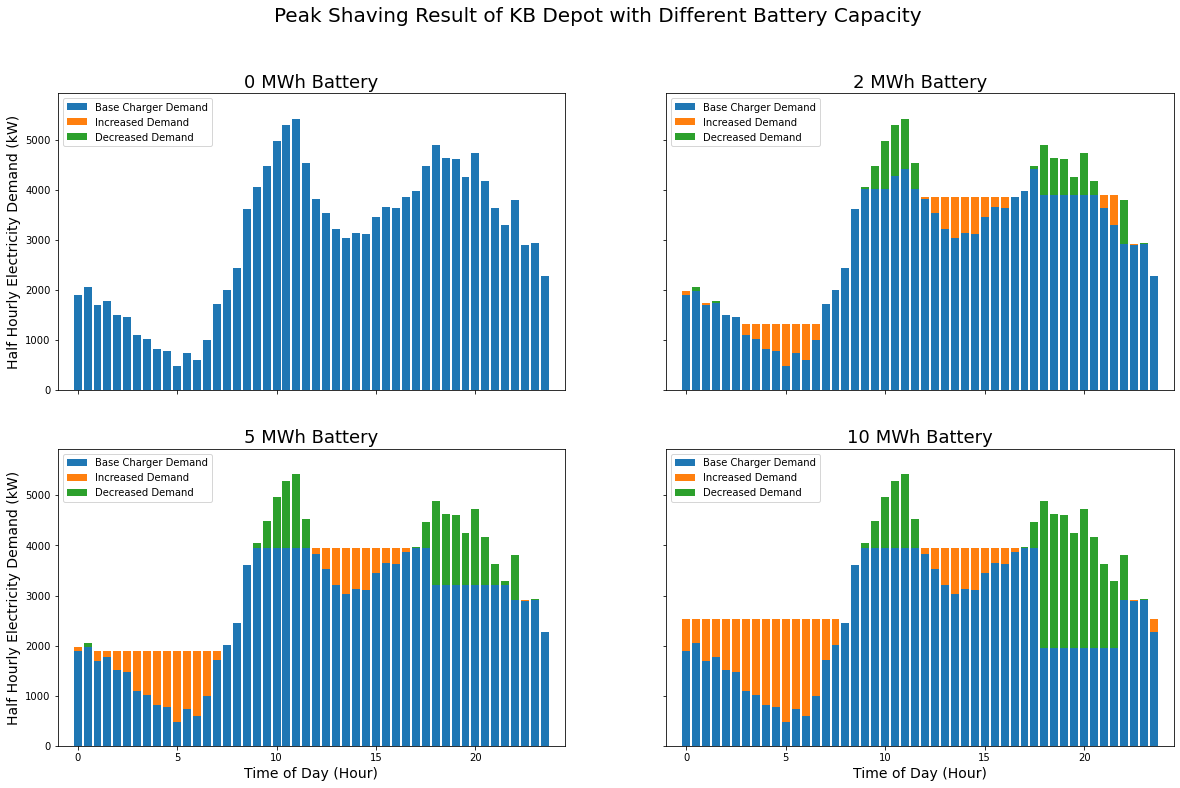

In [60]:
Capacity = [0, 2000 ,5000 ,10000]
x = np.arange(48)/2

result = Depot_opti(Capacity, "KB")

In [61]:
result

,Battery Capacity,Peak (8am-6pm),Peak (6pm-10pm),Peak (10pm-8am),Monthly Cost of Peak Demand,Monthly Cost of Electricity
0,0.0,5418.873858,4890.401732,3801.920897,262352.264867,96518.197608
1,2000.0,4418.873858,3892.668051,2913.982559,211122.455022,96075.662440
2,5000.0,3948.347412,3203.778969,2913.982559,184886.093323,95222.462440
3,10000.0,3948.347412,1953.778969,2913.982559,160511.093323,93800.462440
